## Работа приближенного метода на относительно большой случайной выборке

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.neighbors import KNeighborsRegressor
import sklearn.neighbors

%matplotlib inline

In [5]:
bits = 4096
n_neighbours = 128
os.environ['LSH_SAMPLE_BITS'] = str(bits)

In [18]:
! python ../etc/stub_data_generator.py 100000 ${LSH_SAMPLE_BITS} --out ./ls_stub_train_data
! python ../etc/stub_data_generator.py 10000 ${LSH_SAMPLE_BITS} --out ./ls_stub_test_data

In [3]:
def parse_input(in_file):
    rows = file(in_file).readlines()
    
    N = len(rows)
    X = np.zeros((N, bits))
    
    for row in rows:
        row_fields = row.split()
        row_id = int(row_fields[0])
        for bit in row_fields[1:]:
            X[row_id, int(bit)] = 1
            
    return X

In [6]:
gt_knn = KNeighborsRegressor(metric='hamming')
X_train = parse_input('./ls_stub_train_data')
X_test = parse_input('./ls_stub_test_data')

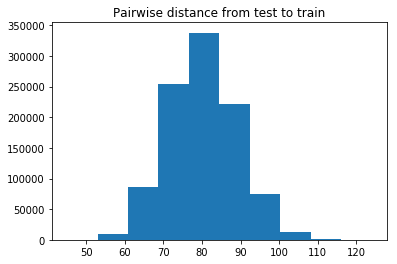

In [13]:
dist = sklearn.neighbors.DistanceMetric.get_metric('hamming')
_ = plt.hist((dist.pairwise(X_test[:1000], X_train[:1000]) * bits).ravel())
plt.title("Pairwise distance from test to train")

Исходя из распределения расстояний от теста до тренировочного набора выберу шар $r_1=50$ и $r_2=75$

## LSH k-rnn result

In [ ]:
! ./krnn -H 1024 -s1024 -k 32 -r 50 -a 0.5 -t0.1 -d4096  ../etc/ls_stub_train_data ../etc/ls_stub_test_data  > ../etc/ls_stub_result

200 МБ памяти, минут 10 на обучение 5 минут на применение

In [29]:
def parse_result(fname):
    rows = file(fname).readlines()
    neighbours = []
    for row in rows:
        neighbours.append([int(x) for x in row.split()[1:]])
    return neighbours

In [36]:
lsh_result = parse_result('../etc/ls_stub_result')

lsh_distances = []
for test_id, neighbours in enumerate(lsh_result):
    lsh_distances+=list(dist.pairwise(X_test[test_id: test_id+1], X_train[neighbours])[0] * bits)
    

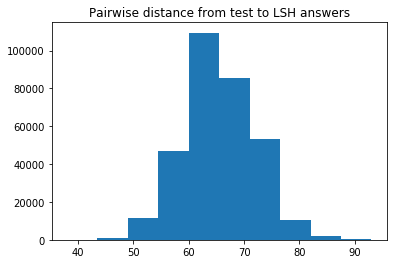

In [37]:
_ = plt.hist(lsh_distances)
plt.title("Pairwise distance from test to LSH answers")

Парные расстояния от ответа примерного метода до теста не абсурдные и это радует

## Sklearn KNN

In [7]:
gt_knn.fit(X_train, np.ones(len(X_train)))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='hamming',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [10]:
%time gt_d, gt_neighbours = gt_knn.kneighbors(X_test, 32)

CPU times: user 51min 50s, sys: 6.31 s, total: 51min 57s
Wall time: 5h 41min 31s


4 ГБ памяти, время выше

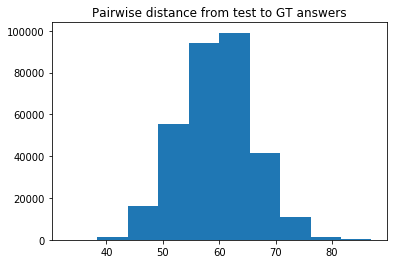

In [39]:
_ = plt.hist(gt_d.ravel()* bits)
plt.title("Pairwise distance from test to GT answers")

Сравни расстояния от ответов честного метода до теста с расстояниями приближенного методы выше, выглядит разумно, ответы приближенного метода дальше, но не сильно.

In [40]:
def ioc(lsh, knn):
    r = []
    for test_id in range(len(lsh)):
        i = len(set(lsh[test_id]) & set(knn[test_id]))
        u = len(set(lsh[test_id]) | set(knn[test_id]))
        r.append(i / float(u))
        
        
    return np.array(r)

ioc_values = ioc(lsh_result, gt_neighbours)

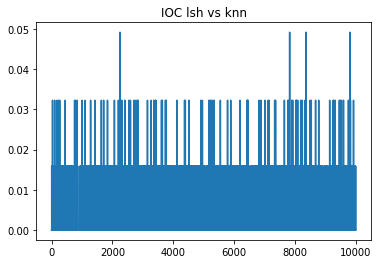

In [41]:
plt.title('IOC lsh vs knn')
plt.plot(ioc_values)

IOC выглядит грустно, но как кажется это предсказуемо - я прошу 32 ближайших соседа расстояния которых будут отличаться на один два бита и выбираю их из выборки в 100000 примеров.

(array([  1.,   0.,   3.,   0.,   0.,   9.,   0.,  14.,   0.,   5.]),
 array([ 69. ,  69.4,  69.8,  70.2,  70.6,  71. ,  71.4,  71.8,  72.2,
         72.6,  73. ]),
 <a list of 10 Patch objects>)

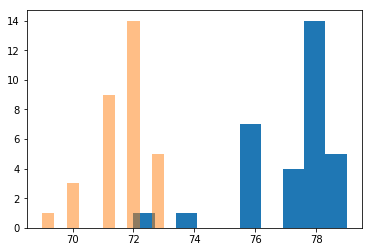

In [48]:
lsh_distances = np.array(lsh_distances).reshape(10000, -1)

plt.hist(lsh_distances[5])
plt.hist(gt_d[5]*bits, alpha=0.5)

Нельзя сказать, что примерный метод (синий) нашел прямо те самые настоящие элементы (рыжий), но если вспомнить о том что я использовал 1024 минихэшей для описания слов размера 4096 то разница в 5-6 бит не выглядит ужасной. Кроме того, эти расстояния у самой кромки шара $r_2$ и в этом смыысле ожидаемы